In [1]:
from google.colab import files

uploaded = files.upload()

Saving iswc.json to iswc.json


In [2]:
import json

with open('iswc.json', 'r') as file:
     iswc = json.load(file)

## JSON input conversion
### From:
[{"year": year,
  "tkg": link,
  "metrics": [{"metric": metric_name,
               "concepts": [{uri: value},
                            (...)]},
              (...)]},
 (...)]
 
 ### To:
{metric_name: {uri: {year: value,
                     (...)},
               (...)},
 (...)}

In [3]:
all_concepts = set()
all_metrics = set()
all_years = set()

data = dict()

for entry in iswc:
    year = entry['year']
    all_years.add(year)
    for metrics in entry['metrics']:
        metric_name = metrics['metric']
        all_metrics.add(metric_name)
        metric_concepts = metrics['concepts']
        for concept in metric_concepts:
            for key, value in concept.items():
                all_concepts.add(key)
                #print("{} : {} : {} : {} ".format(metric_name, year, key, value))
                curr = {key: {year: value}}
                if metric_name in data.keys():
                    if key in data[metric_name].keys():
                        data[metric_name][key].update(curr[key])
                    else:
                        data[metric_name].update(curr)
                else:
                    data[metric_name] = curr

print('# of concepts: {}'.format(len(all_concepts)))
print('# of metrics: {}'.format(len(all_metrics)))
print('# of editions: {} ({} to {})'.format(len(all_years),\
                                            min(all_years), max(all_years)))

# of concepts: 958
# of metrics: 12
# of editions: 19 (2002 to 2020)


### Method to create a dataframe for a metric's annual data

In [4]:
import pandas as pd

def create_df(metric="dumb", verbose=True):
    df = pd.DataFrame(data[metric]).sort_index(ascending=True)
    if verbose:
        print(f'Annual data for {metric}')
        display(df)
    return df

### Method to print the TKGVR for a given metric data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_df_heatmap(df, title="", dpi=100, num_lines=len(all_concepts)):
    df_t = df.transpose()
    # Sort by descending amount of NaNs
    df_heat = df_t.iloc[df_t.isnull().sum(axis=1).mul(1).argsort()].head(num_lines)
    plt.figure(figsize=(8, 6), dpi=dpi)
    ax = sns.heatmap(df_heat, yticklabels=num_lines<=50, square=False, cmap='Oranges')
    plt.title(title)
    plt.show()

## Print a metric's data and plot its TKGVR

Annual data for indegree


,http://local/local.owl#semantic_web,http://local/local.owl#semantics,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#rdf,http://local/local.owl#ontology,http://local/local.owl#world_wide_web,http://local/local.owl#semantic_web_technologies,http://local/local.owl#web_resources,http://local/local.owl#software,http://local/local.owl#software_agents,http://local/local.owl#xml,http://local/local.owl#web_mining,http://local/local.owl#knowledge_sharing,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#artificial_intelligence,http://local/local.owl#inference_engine,http://local/local.owl#internet,http://local/local.owl#rdf_graphs,http://local/local.owl#virtual_communities,http://local/local.owl#application_layer,http://local/local.owl#semantic_web_applications,http://local/local.owl#statistical_analysis,http://local/local.owl#ontology_languages,http://local/local.owl#grid_services,http://local/local.owl#knowledge_representation,http://local/local.owl#semantic_annotations,http://local/local.owl#query_languages,http://local/local.owl#social_network_analysis,http://local/local.owl#description_logics,http://local/local.owl#collaborative_work,http://local/local.owl#open_source_project,http://local/local.owl#peertopeer_network,http://local/local.owl#petri_nets,http://local/local.owl#information_retrieval,http://local/local.owl#resource_sharing,http://local/local.owl#description_logic,http://local/local.owl#logic_programming,http://local/local.owl#virtual_community,...,http://local/local.owl#network_architecture,http://local/local.owl#sat_solver,http://local/local.owl#recommender_systems,http://local/local.owl#graphbased_representation,http://local/local.owl#type_safety,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#computing_systems,http://local/local.owl#mechanism_design,http://local/local.owl#interpretability,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#relational_learning,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#raster_data,http://local/local.owl#interpreter,http://local/local.owl#query_optimizer,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#syntactic_structure,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#gaussian_distributions,http://local/local.owl#search_behaviors,http://local/local.owl#classification_models,http://local/local.owl#similar_cases,http://local/local.owl#random_walks,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#steiner_tree,http://local/local.owl#supervised_classifiers,http://local/local.owl#efficient_computation,http://local/local.owl#data_protection,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#text_categorization,http://local/local.owl#interleaves
2002,0.010601,0.003949,0.003326,0.002702,0.002494,0.002494,0.001455,0.001247,0.001039,0.001039,0.001039,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000416,0.000416,0.000416,0.000416,0.000416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.004221,0.003236,NaN,0.000141,0.001688,0.004362,0.001266,0.000422,0.000985,0.000141,0.000422,0.000281,NaN,NaN,0.000844,NaN,NaN,0.000422,0.000141,0.000281,NaN,NaN,NaN,NaN,0.000844,NaN,NaN,0.000422,0.000281,NaN,0.000422,NaN,NaN,NaN,NaN,0.000422,0.0002

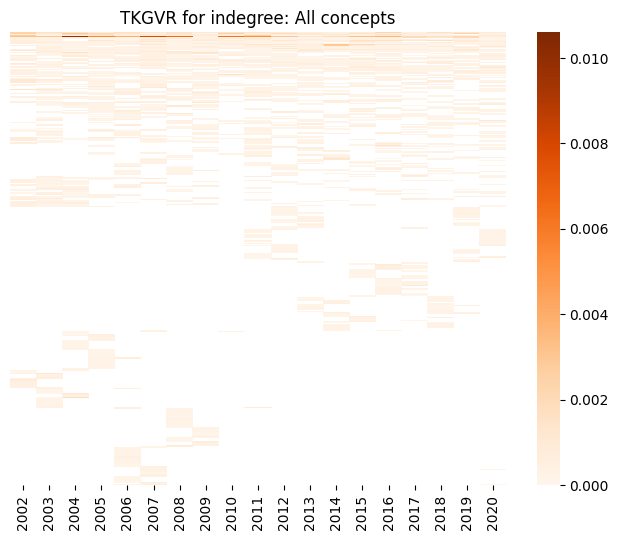

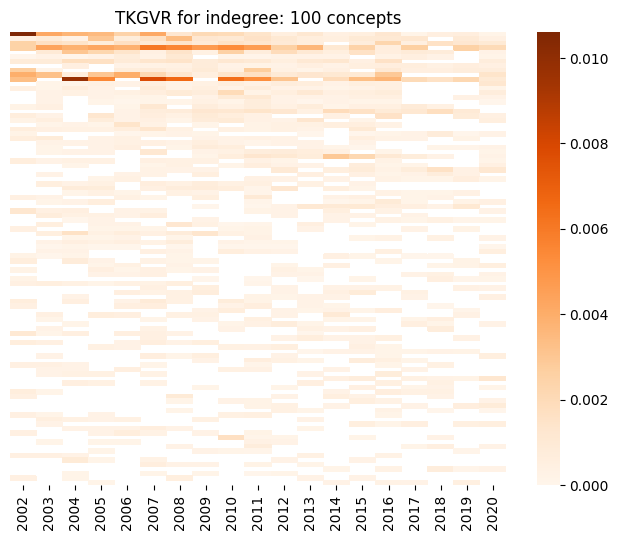

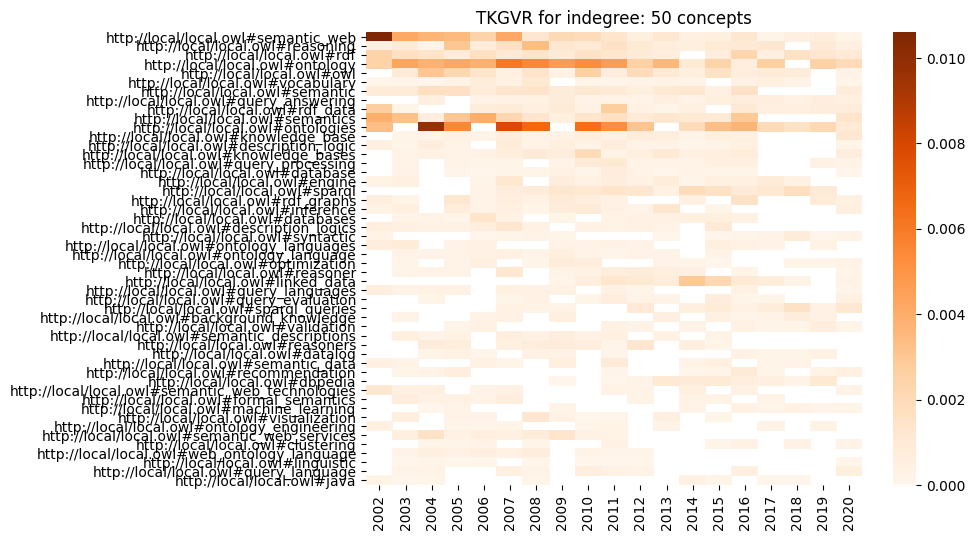

In [6]:
metric_of_interest = "indegree"

df = create_df(metric=metric_of_interest)

plot_df_heatmap(df, title=f'TKGVR for {metric_of_interest}: All concepts')
plot_df_heatmap(df, title=f'TKGVR for {metric_of_interest}: 100 concepts', num_lines=100)
plot_df_heatmap(df, title=f'TKGVR for {metric_of_interest}: 50 concepts', num_lines=50)

### Method to plot a series

In [7]:
def plot_series(df, x, y, breakpoints=[], title="", xlabel='Year', ylabel='Value', dpi=100, type='line'):
    plt.figure(figsize=(12,5), dpi=dpi)
    if type == 'bar':
        plt.bar(x, y)
    else:
        plt.plot(x, y, 'o-')
        plt.grid()
    for i in breakpoints:
        plt.axvline(i, color='red', linestyle='dashed')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Print a series that describes a given concept evolution over the years, considering a specific metric

In [8]:
concept_of_interest = 'http://local/local.owl#reasoning'

concept_series = df[concept_of_interest]
concept_series

2002    0.000416
2003    0.000844
2004    0.000264
2005    0.002997
2006    0.000774
2007    0.001630
2008    0.003388
2009    0.001224
2010    0.001042
2011    0.001559
2012    0.001091
2013    0.000648
2014    0.000554
2015    0.001011
2016    0.001076
2017    0.001263
2018         NaN
2019    0.000969
2020    0.000426
Name: http://local/local.owl#reasoning, dtype: float64

In [9]:
concept_series.describe()

count    18.000000
mean      0.001176
std       0.000826
min       0.000264
25%       0.000679
50%       0.001026
75%       0.001253
max       0.003388
Name: http://local/local.owl#reasoning, dtype: float64

## Method to determine the trend of a Series

In [10]:
import numpy as np

def trendline(data, order=1):
    if len(set(data)) == 1: # constant data
       return 0

    coeffs = np.polyfit(data.index.values.astype(int), list(data.fillna(0)), order)
    slope = coeffs[-2]
    return float(slope)

series_slope = trendline(concept_series)
if series_slope > 0:
    print("Increasing trend")
elif series_slope < 0:
    print("Decreasing trend")
else:
    print("Neutral trend")

Decreasing trend


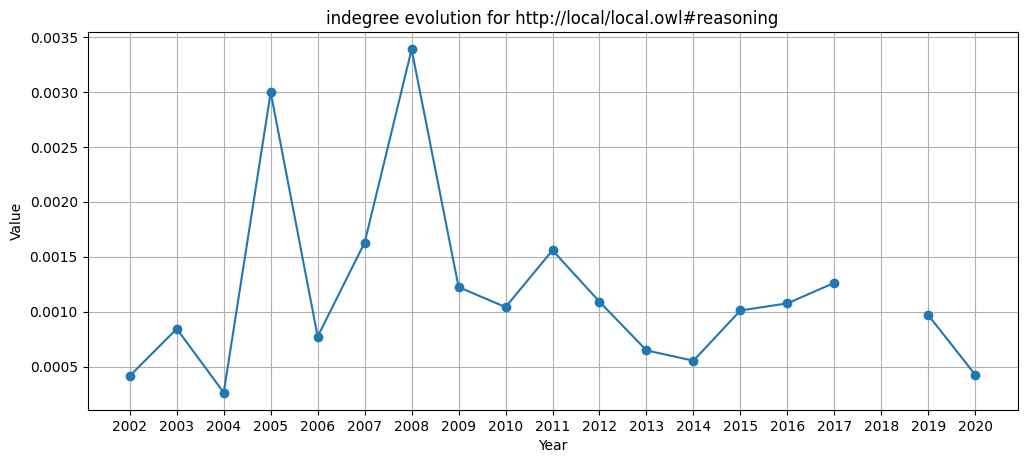

Max. value on 2008: 0.0033879929529746573
Min. value on 2004: 0.0002637826431020839


In [11]:
plot_series(concept_series, x=concept_series.index, y=concept_series.values,\
        title='{} evolution for {}'.format(metric_of_interest, concept_of_interest))

print(f'Max. value on {concept_series.idxmax()}: {concept_series.loc[concept_series.idxmax()]}')
print(f'Min. value on {concept_series.idxmin()}: {concept_series.loc[concept_series.idxmin()]}')

## Detect breakpoints in a series 

In [12]:
pip install jenkspy

     |████████████████████████████████| 55 kB 2.4 MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=70416 sha256=cc19aac7f0f3ce92c8cabefd747e2bb15af469b86ca9c761194f03136a8544d2
  Stored in directory: /root/.cache/pip/wheels/d8/d1/42/9bd05164ef706b84674905892f0542f8db6ac4a652473ca7e0
Successfully built jenkspy


In [13]:
import jenkspy

# From:
# https://medium.com/analytics-vidhya/jenks-natural-breaks-best-range-finder-algorithm-8d1907192051
# https://pbpython.com/natural-breaks.html
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, nb_class=classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

def get_breakpoints(series):
    gvf = 0.0
    nclasses = 2
    while gvf < .8:
        gvf = goodness_of_variance_fit(series.fillna(0), nclasses)
        nclasses += 1

    breaks_values = jenkspy.jenks_breaks(series, nb_class=nclasses)
    breaks = []
    for v in breaks_values:
        if v == 0: # NaN case
            continue
        idx = concept_series.index.values[concept_series == v][0]
        breaks.append(idx)
    return breaks

/usr/local/lib/python3.7/dist-packages/jenkspy/core.py:103: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


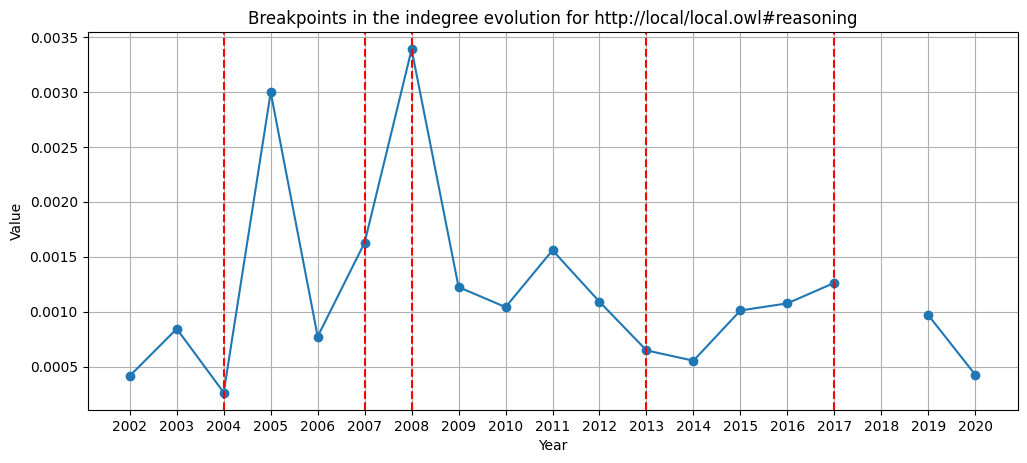

In [14]:
plot_series(concept_series, breakpoints=get_breakpoints(concept_series), x=concept_series.index, y=concept_series.values,\
        title='Breakpoints in the {} evolution for {}'.format(metric_of_interest, concept_of_interest))